# 从零开始构建一个大型语言模型

本文是使用PyTorch从0开始逐步实现一个类似ChatGPT那样的大型语言模型（以下简称LLM），步骤大体分为如下：
  - 数据准备与预处理
  - 模型架构与实现
  - 模型训练与评估
  - 文本生成与微调

## 前言

如果你让ChatGPT继续输出“每一次努力都让你感动”后面的内容，ChatGPT会自动延续后续内容并输出，我第一次看到就对此产生了好奇。本文是实现一个类似这样的类GPT模型，且针对文本数据，力求尽量不出现公式，尽量减少专业术语，使用简单清晰的词语进行解释，并给出代码实现。初步可能为了更好的理解，实现一个简单的版本，它可能输出的并不理想，但最终会调整为适合现有大模型的复杂实现思路。故你可以将本文的目的理解为新手入门LLM通识训练。
废话不多说，现在开始！


首先，我们要先明确我们此行的目的：给一段输入“每一次努力都让你感动”，经过模型的处理加工后，输出后续的内容“未来的精彩由此慢慢绽放”。用程序化的语言可以这么表达：输入input，经过model的处理，输出output。一般情况下，模型是依据历史文本来生成固定长度的内容，不可能无限制的生成，所以还需要限定输入长度和输出长度，由此我们定义一个简单的文本生成方法 `generate_text_simple`:

In [75]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    return idx

这个方法就是最终我们需要输出新内容所需要的，我们对这个方法进行解释：
  - `model` : 用来生成文本的大规模语言模型。这个模型经过训练，可以根据给定的输入（上下文）预测并生成接下来最有可能出现的文本。
  - `idx` : 这通常指代的是输入文本序列中每个词或标记（token）在词汇表中的索引位置。在处理过程中，文本首先会被分词器转换成一系列的标记，然后每个标记会根据词汇表映射为一个索引值，用于模型的计算。
  - `max_new_tokens` : 这是设定的一个上限，表示模型在生成新文本时最多可以输出的新标记数量。它有助于控制生成文本的长度，避免生成过长的内容。
  - `context_size` : 模型在做预测时所参考的历史信息长度，即每次提供给模型的输入序列的长度。较大的上下文大小可以让模型记住更多过去的信息，从而可能生成更加连贯和有意义的文本。


为什么要用词汇表索引位置，而不是文本本身？
- 数字化表示：计算机擅长处理数值数据
- 减少复杂度：减少计算复杂度和存储需求
- 迁移学习：可以在另外一套定义好的词汇表上使用预训练的模型
- 支持嵌入层：离散的词汇转换为连续的密集向量，捕捉句子结构和上下文信息
- 泛化能力：学习关系模式，增强适应性

我们试着简单的实现这个方法：
- 首先定义 `model` 参数的类型，名字为 `GPTModel`, 因为我们不知道如何实现它，姑且暂时将输入作为输出返回:

In [76]:
import torch
import torch.nn as nn
print("torch version:",torch.__version__)

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, in_idx):
        return in_idx


torch version: 2.5.1+cu124


- 然后实现 `generate_text_simple` 方法:

In [77]:
import random
def generate_text_simple(model, idx, max_new_tokens, context_size):

    for _ in range(max_new_tokens):
        idx_cond = idx[-context_size:] # 获取上下文token

        logits = model(idx_cond) # 通过模型生成后续序列
        
        idx_next = random.choices(logits)[0] # 随机选择一个

        idx.append(idx_next) #将下一个预测添加到序列中

    return idx

- 最后我们进行测试，并且有了输出，最大续写5个字，每次只处理上下文4个长度：

In [78]:
model = GPTModel()
in_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
generate_text_simple(model=model, idx=in_idx, max_new_tokens=5, context_size=4)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 14, 14, 14, 16, 16]

但这个结果人类看不懂，并且是很随机的输出，所以它毫无意义。因此我们需要将这个模型进行完善，分析以上过程和代码，我们需要解决的问题有：
- 将输入文本转为词汇表的索引位置
- 实现模型预测，既完成模型训练
- 选择最有可能或最优的预测，而不是随机输出
- 使用正常的文本来测试，且将结果输出为人类能看懂的文本

## 1. 数据准备与预处理

### 1.1 简单分词器

首先，要解决的是将文本转换为数值表示。为此我们需要一份词汇表，现在有很多公开的词汇表可以使用。但为了学习目的，我们从一份中文内容中自定义词汇表，当然这篇中文文章也是后续训练数据集。

- 加载我们要处理的原始文本
- 《每一滴汗水都是未来花朵的养分》是由GPT根据我的提示词生成的文章。

In [79]:
with open("the-road.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("总字数：", len(raw_text))
print(raw_text[:99])

总字数： 778
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事中的主角。每一天，我们都面临着选择，每一个选择都是一条通往未知的道路。而在这无数的选择中，有一种选择是永恒不变的——那就是付出努


- 然后我们需要将这篇文章 `token` 化，考虑一些常见的中文标点符号

In [80]:
import re
pattern = r'([\u4e00-\u9fff，。_！？、；：“”‘’()（）——])' # 匹配常见的中文标点符号
result = [token for token in re.split(pattern, raw_text) if token.strip()] # 分割并移除空字符串
print(result)
print(len(result))

['每', '一', '滴', '汗', '水', '都', '是', '未', '来', '花', '朵', '的', '养', '分', '—', '—', '在', '生', '命', '的', '旅', '途', '上', '，', '我', '们', '每', '个', '人', '都', '是', '自', '己', '故', '事', '中', '的', '主', '角', '。', '每', '一', '天', '，', '我', '们', '都', '面', '临', '着', '选', '择', '，', '每', '一', '个', '选', '择', '都', '是', '一', '条', '通', '往', '未', '知', '的', '道', '路', '。', '而', '在', '这', '无', '数', '的', '选', '择', '中', '，', '有', '一', '种', '选', '择', '是', '永', '恒', '不', '变', '的', '—', '—', '那', '就', '是', '付', '出', '努', '力', '。', '每', '一', '次', '的', '努', '力', '，', '无', '论', '大', '小', '，', '都', '在', '悄', '然', '改', '变', '着', '我', '们', '的', '命', '运', '轨', '迹', '。', '它', '们', '累', '积', '起', '来', '，', '成', '为', '我', '们', '成', '长', '道', '路', '上', '最', '宝', '贵', '的', '财', '富', '。', '每', '一', '次', '努', '力', '都', '让', '你', '感', '动', '。', '这', '不', '仅', '仅', '是', '对', '个', '人', '成', '就', '的', '一', '种', '赞', '美', '，', '更', '是', '对', '坚', '持', '和', '毅', '力', '的', '颂', '扬', '。', '当', '我', '们', '看', '到', '运', '动', '员', '在', '赛',

- 从这 `768` 个 `token` 中，我们构建一个包含所有唯一 `token` 的词汇表：

In [81]:
all_tokens = sorted(set(result))
vocab = {token : integer for integer,token  in enumerate(all_tokens)}
vocab_size = len(vocab)
print(vocab_size)

321


打印前后5个元素看一下效果：

In [82]:
for i, item in enumerate(vocab.items()):
    if i <= 5 or i >= (vocab_size-5):
        print(item)
    elif i == 6 or i == (vocab_size-5):
        print('...')

(',', 0)
('—', 1)
('“', 2)
('”', 3)
('、', 4)
('。', 5)
...
('验', 316)
('默', 317)
('鼓', 318)
('，', 319)
('；', 320)


- 接下来我们要用这个词汇表将文本进行 `token` 化，可以理解成进行 `编码`, 当然后续也需要将这些 `token` ID 转化回文本形式，即进行 `解码`，所以我们将实现这两个方法，并放到一个 `SimpleTokenizer` 类中。其中，`encode` 实现将文本转换为  `token` ID, `decode` 实现将 `token` ID 重新转换为文本：

In [83]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        pattern = r'([\u4e00-\u9fff，。_！？、；：“”‘’()（）——])' # 匹配常见的中文标点符号
        preprocessed = [item.strip() for item in re.split(pattern, text) if item.strip()] # 分割并移除空字符串
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = "".join([self.int_to_str[i] for i in ids])
        return text

我们可以使用 `SimpleTokenizer` 将文本编码为数值，然后可以将数值嵌入作为LLM的输入：

In [84]:
tokenizer = SimpleTokenizer(vocab=vocab)

ids = tokenizer.encode("每一次努力都让你感动")
print(ids)

[199, 6, 194, 55, 50, 298, 264, 38, 142, 53]


我们还可以将这些数值解码回文本：

In [85]:
tokenizer.decode(ids)

'每一次努力都让你感动'

- 当然这个分词器还不完整，例如对于未知字没有特殊的处理，会导致代码运行错误，为此，我们可以添加一些特殊的标记：
    - `"<|unk|>"` 表示未知单词
    - `"<|endoftext|>"` 表示文本的结尾

In [86]:
all_tokens = sorted(set(result))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

323
('鼓', 318)
('，', 319)
('；', 320)
('<|endoftext|>', 321)
('<|unk|>', 322)


同时需要修改 `SimpleTokenizer`，以便知道何时以及如何使用新的`<unk>` 标记

In [87]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        pattern = r'([\u4e00-\u9fff，。_！？、；：“”‘’()（）——])' # 匹配常见的中文标点符号
        preprocessed = [item.strip() for item in re.split(pattern, text) if item.strip()] # 分割并移除空字符串
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = "".join([self.int_to_str[i] for i in ids])
        return text

- **这个分词器有没有什么问题？** 
  - **当然，因为大部分情况下需要保留词语或短语，而不只仅仅单个字，它不会理解语义或语法结构，只是机械式的切割** 
  - **这里我们暂时以这个为主，后续来进行完善，假设我们分词器已完成，来完成剩余部分。**  

让我们尝试使用修改后的标记器来标记文本：

In [88]:
tokenizer = SimpleTokenizer(vocab=vocab)

ids = tokenizer.encode("每一次努力都让你感动啊")
print(ids)

[199, 6, 194, 55, 50, 298, 264, 38, 142, 53, 322]


In [89]:
tokenizer.decode(ids)

'每一次努力都让你感动<|unk|>'

对整个原始文本进行编码：

In [90]:
ids = tokenizer.encode(raw_text + "<|endoftext|>")
print(ids)

[199, 6, 210, 204, 201, 298, 176, 184, 188, 256, 185, 223, 41, 45, 1, 1, 87, 219, 80, 223, 170, 293, 7, 319, 145, 32, 199, 12, 25, 298, 176, 255, 121, 165, 22, 13, 223, 16, 262, 5, 199, 6, 99, 319, 145, 32, 298, 313, 14, 228, 292, 154, 319, 199, 6, 12, 292, 154, 298, 176, 6, 187, 294, 130, 184, 229, 223, 296, 277, 5, 250, 87, 287, 171, 168, 223, 292, 154, 13, 319, 181, 6, 234, 292, 154, 176, 202, 137, 9, 68, 223, 1, 1, 297, 118, 176, 29, 44, 55, 50, 5, 199, 6, 194, 223, 55, 50, 319, 171, 266, 98, 116, 319, 298, 87, 139, 214, 163, 68, 228, 145, 32, 223, 80, 286, 280, 289, 5, 106, 32, 241, 236, 275, 188, 319, 144, 15, 145, 32, 144, 304, 296, 277, 7, 180, 108, 272, 223, 270, 112, 5, 199, 6, 194, 55, 50, 298, 264, 38, 142, 53, 5, 287, 9, 26, 26, 176, 113, 12, 25, 144, 118, 223, 6, 234, 274, 247, 319, 179, 176, 113, 90, 155, 81, 198, 50, 223, 314, 150, 5, 128, 145, 32, 227, 47, 286, 53, 79, 87, 273, 89, 7, 157, 205, 204, 201, 319, 235, 105, 111, 87, 109, 316, 110, 300, 172, 96, 303, 231, 31

In [91]:
tokenizer.decode(ids)

'每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事中的主角。每一天，我们都面临着选择，每一个选择都是一条通往未知的道路。而在这无数的选择中，有一种选择是永恒不变的——那就是付出努力。每一次的努力，无论大小，都在悄然改变着我们的命运轨迹。它们累积起来，成为我们成长道路上最宝贵的财富。每一次努力都让你感动。这不仅仅是对个人成就的一种赞美，更是对坚持和毅力的颂扬。当我们看到运动员在赛场上挥洒汗水，科学家在实验室里日夜钻研，或是普通劳动者在岗位上默默耕耘时，我们内心深处都会被触动。这种感动源于对人类潜能的敬佩，以及对那些为了梦想而不惜一切代价的人们的尊重。未来的精彩由此慢慢绽放。就像一朵花从种子开始，在土壤中吸收养分，经过长时间的孕育，最终破土而出，展现出它的美丽一样。我们的未来也是这样，通过不断的努力，我们将积累起足够的力量，去迎接即将到来的挑战与机遇。每一次小小的进步，每一点微不足道的成功，都是通向更大辉煌的基石。在这个过程中，我们需要明白，成功并非一蹴而就。它是由无数次失败、反思和再尝试构成的。因此，当我们在追求梦想的路上遇到困难时，不要轻易放弃。相反，应该把每一次挫折看作是学习的机会，从中吸取教训，并且更加坚定地朝着目标前进。同时，我们也应当珍惜身边那些支持和鼓励我们的人。他们可能是家人、朋友、老师或者是陌生人。正是有了他们的陪伴和支持，我们才能更有勇气面对生活中的风风雨雨。所以，让我们心怀感恩之心，用实际行动回报那些帮助过我们的人。总之，“每一次努力都让你感动,未来的精彩由此慢慢绽放”这句话不仅仅是一句简单的口号，它蕴含着深刻的人生哲理。它提醒我们要珍惜每一个当下，用心去感受生命中的点滴美好；同时也激励我们在面对困难时不退缩，勇往直前。因为只有经历了风雨洗礼后的彩虹，才会显得格外绚丽多彩。<|endoftext|>'

### 1.2 处理文本数据

最后，为了将该文本变成我们的第一个训练数据集，我们需要构建对它进行处理，以实现对模型的训练：

- 第一步，构建输入输出组合，所谓输入输出组合就是根据前面的所有字来预测下一个字

为了说明这个问题，我们使用原始文档进行说明

In [92]:
import re
preprocessed = [token for token in re.split(pattern, raw_text) if token.strip()] #将原始文档进行分割去除空字符串

for i in range(1, len(preprocessed)):
    input = preprocessed[:i]
    output = preprocessed[i]

    print("".join(input), "——>", output)


每 ——> 一
每一 ——> 滴
每一滴 ——> 汗
每一滴汗 ——> 水
每一滴汗水 ——> 都
每一滴汗水都 ——> 是
每一滴汗水都是 ——> 未
每一滴汗水都是未 ——> 来
每一滴汗水都是未来 ——> 花
每一滴汗水都是未来花 ——> 朵
每一滴汗水都是未来花朵 ——> 的
每一滴汗水都是未来花朵的 ——> 养
每一滴汗水都是未来花朵的养 ——> 分
每一滴汗水都是未来花朵的养分 ——> —
每一滴汗水都是未来花朵的养分— ——> —
每一滴汗水都是未来花朵的养分—— ——> 在
每一滴汗水都是未来花朵的养分——在 ——> 生
每一滴汗水都是未来花朵的养分——在生 ——> 命
每一滴汗水都是未来花朵的养分——在生命 ——> 的
每一滴汗水都是未来花朵的养分——在生命的 ——> 旅
每一滴汗水都是未来花朵的养分——在生命的旅 ——> 途
每一滴汗水都是未来花朵的养分——在生命的旅途 ——> 上
每一滴汗水都是未来花朵的养分——在生命的旅途上 ——> ，
每一滴汗水都是未来花朵的养分——在生命的旅途上， ——> 我
每一滴汗水都是未来花朵的养分——在生命的旅途上，我 ——> 们
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们 ——> 每
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每 ——> 个
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个 ——> 人
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人 ——> 都
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都 ——> 是
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是 ——> 自
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自 ——> 己
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己 ——> 故
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故 ——> 事
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事 ——> 中
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事中 ——> 的
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事中的 ——> 主
每一滴汗水都是未来花朵的养分——在生命的旅途上，我们每个人都是自己故事中的主

实际上，输入和输出都是固定的长度，例如输入选择前面4个字，输出是输入向后移动1个字，这样有利于计算机处理，否则在运算时候对于不固定的长度处理复杂度较高，现在修改一下程序：

In [93]:
context_size = 4
for i in range(0, len(preprocessed) - context_size): # -context_size 是因为最后一组不足以构建一个组合
    # 输入取固定的长度
    input = preprocessed[i:i+context_size]

    # 输出是输入向后移动一个字的固定长度
    output = preprocessed[i+1:i+context_size+1]

    print("".join(input), "——>", "".join(output))


每一滴汗 ——> 一滴汗水
一滴汗水 ——> 滴汗水都
滴汗水都 ——> 汗水都是
汗水都是 ——> 水都是未
水都是未 ——> 都是未来
都是未来 ——> 是未来花
是未来花 ——> 未来花朵
未来花朵 ——> 来花朵的
来花朵的 ——> 花朵的养
花朵的养 ——> 朵的养分
朵的养分 ——> 的养分—
的养分— ——> 养分——
养分—— ——> 分——在
分——在 ——> ——在生
——在生 ——> —在生命
—在生命 ——> 在生命的
在生命的 ——> 生命的旅
生命的旅 ——> 命的旅途
命的旅途 ——> 的旅途上
的旅途上 ——> 旅途上，
旅途上， ——> 途上，我
途上，我 ——> 上，我们
上，我们 ——> ，我们每
，我们每 ——> 我们每个
我们每个 ——> 们每个人
们每个人 ——> 每个人都
每个人都 ——> 个人都是
个人都是 ——> 人都是自
人都是自 ——> 都是自己
都是自己 ——> 是自己故
是自己故 ——> 自己故事
自己故事 ——> 己故事中
己故事中 ——> 故事中的
故事中的 ——> 事中的主
事中的主 ——> 中的主角
中的主角 ——> 的主角。
的主角。 ——> 主角。每
主角。每 ——> 角。每一
角。每一 ——> 。每一天
。每一天 ——> 每一天，
每一天， ——> 一天，我
一天，我 ——> 天，我们
天，我们 ——> ，我们都
，我们都 ——> 我们都面
我们都面 ——> 们都面临
们都面临 ——> 都面临着
都面临着 ——> 面临着选
面临着选 ——> 临着选择
临着选择 ——> 着选择，
着选择， ——> 选择，每
选择，每 ——> 择，每一
择，每一 ——> ，每一个
，每一个 ——> 每一个选
每一个选 ——> 一个选择
一个选择 ——> 个选择都
个选择都 ——> 选择都是
选择都是 ——> 择都是一
择都是一 ——> 都是一条
都是一条 ——> 是一条通
是一条通 ——> 一条通往
一条通往 ——> 条通往未
条通往未 ——> 通往未知
通往未知 ——> 往未知的
往未知的 ——> 未知的道
未知的道 ——> 知的道路
知的道路 ——> 的道路。
的道路。 ——> 道路。而
道路。而 ——> 路。而在
路。而在 ——> 。而在这
。而在这 ——> 而在这无
而在这无 ——> 在这无数
在这无数 —

另外，我们还可以给这个数据加载方法设置一个移动幅度，比如每次移动两个字：

In [94]:
context_size = 4
stride = 2
for i in range(0, len(preprocessed) - context_size, stride): # -context_size 是因为最后一组不足以构建一个组合
    # 输入取固定的长度
    input = preprocessed[i : i + context_size]

    # 输出是输入向后移动一个字的固定长度
    output = preprocessed[i + 1 : i + context_size + 1]

    print("".join(input), "——>", "".join(output))


每一滴汗 ——> 一滴汗水
滴汗水都 ——> 汗水都是
水都是未 ——> 都是未来
是未来花 ——> 未来花朵
来花朵的 ——> 花朵的养
朵的养分 ——> 的养分—
养分—— ——> 分——在
——在生 ——> —在生命
在生命的 ——> 生命的旅
命的旅途 ——> 的旅途上
旅途上， ——> 途上，我
上，我们 ——> ，我们每
我们每个 ——> 们每个人
每个人都 ——> 个人都是
人都是自 ——> 都是自己
是自己故 ——> 自己故事
己故事中 ——> 故事中的
事中的主 ——> 中的主角
的主角。 ——> 主角。每
角。每一 ——> 。每一天
每一天， ——> 一天，我
天，我们 ——> ，我们都
我们都面 ——> 们都面临
都面临着 ——> 面临着选
临着选择 ——> 着选择，
选择，每 ——> 择，每一
，每一个 ——> 每一个选
一个选择 ——> 个选择都
选择都是 ——> 择都是一
都是一条 ——> 是一条通
一条通往 ——> 条通往未
通往未知 ——> 往未知的
未知的道 ——> 知的道路
的道路。 ——> 道路。而
路。而在 ——> 。而在这
而在这无 ——> 在这无数
这无数的 ——> 无数的选
数的选择 ——> 的选择中
选择中， ——> 择中，有
中，有一 ——> ，有一种
有一种选 ——> 一种选择
种选择是 ——> 选择是永
择是永恒 ——> 是永恒不
永恒不变 ——> 恒不变的
不变的— ——> 变的——
的——那 ——> ——那就
—那就是 ——> 那就是付
就是付出 ——> 是付出努
付出努力 ——> 出努力。
努力。每 ——> 力。每一
。每一次 ——> 每一次的
一次的努 ——> 次的努力
的努力， ——> 努力，无
力，无论 ——> ，无论大
无论大小 ——> 论大小，
大小，都 ——> 小，都在
，都在悄 ——> 都在悄然
在悄然改 ——> 悄然改变
然改变着 ——> 改变着我
变着我们 ——> 着我们的
我们的命 ——> 们的命运
的命运轨 ——> 命运轨迹
运轨迹。 ——> 轨迹。它
迹。它们 ——> 。它们累
它们累积 ——> 们累积起
累积起来 ——> 积起来，
起来，成 ——> 来，成为
，成为我 ——> 成为我们
为我们成 ——> 我们成长
们成长道 ——> 成长道路
长道路上 ——> 道路上最
路上最宝 —

- 第二步，通过上一节的简单分词器进行 `token` 化

In [95]:
import re
context_size = 4
stride = 2
for i in range(0, len(preprocessed) - context_size, stride): # -context_size 是因为最后一组不足以构建一个组合
    # 输入取固定的长度
    input = preprocessed[i:i+context_size]

    # 输出是输入向后移动一个字的固定长度
    output = preprocessed[i+1:i+context_size+1]

    print(tokenizer.encode("".join(input)), "---->", tokenizer.encode("".join(output)))

[199, 6, 210, 204] ----> [6, 210, 204, 201]
[210, 204, 201, 298] ----> [204, 201, 298, 176]
[201, 298, 176, 184] ----> [298, 176, 184, 188]
[176, 184, 188, 256] ----> [184, 188, 256, 185]
[188, 256, 185, 223] ----> [256, 185, 223, 41]
[185, 223, 41, 45] ----> [223, 41, 45, 1]
[41, 45, 1, 1] ----> [45, 1, 1, 87]
[1, 1, 87, 219] ----> [1, 87, 219, 80]
[87, 219, 80, 223] ----> [219, 80, 223, 170]
[80, 223, 170, 293] ----> [223, 170, 293, 7]
[170, 293, 7, 319] ----> [293, 7, 319, 145]
[7, 319, 145, 32] ----> [319, 145, 32, 199]
[145, 32, 199, 12] ----> [32, 199, 12, 25]
[199, 12, 25, 298] ----> [12, 25, 298, 176]
[25, 298, 176, 255] ----> [298, 176, 255, 121]
[176, 255, 121, 165] ----> [255, 121, 165, 22]
[121, 165, 22, 13] ----> [165, 22, 13, 223]
[22, 13, 223, 16] ----> [13, 223, 16, 262]
[223, 16, 262, 5] ----> [16, 262, 5, 199]
[262, 5, 199, 6] ----> [5, 199, 6, 99]
[199, 6, 99, 319] ----> [6, 99, 319, 145]
[99, 319, 145, 32] ----> [319, 145, 32, 298]
[145, 32, 298, 313] ----> [32, 298

- 最后，我们创建一个 `GPTDataset` 来实现数据加载，从输入文本中提取块

In [96]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, context_size, stride):
        self.input_ids = []
        self.output_ids = []

        token_ids = tokenizer.encode(text)

        for i in range(0, len(token_ids) - context_size, stride): # -context_size 是因为最后一组不足以构建一个组合
            # 输入取固定的长度
            input = token_ids[i:i+context_size]

            # 输出是输入向后移动一个字的固定长度
            output = token_ids[i+1:i+context_size+1]

            self.input_ids.append(torch.tensor(input))
            self.output_ids.append(torch.tensor(output))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        return self.input_ids[index], self.output_ids[index]


使用 `create_dataloader` 来创建一个数据加载器，注意这里有个参数 `batch_size`，指的是批量大小，对数据集进行批量并行计算可提高效率，上面我们输出的那些例子都是 `batch_size=1` 的情况，实际训练中，这个参数可进行调整以提升效率，使结果更加稳定。

In [97]:
def create_dataloader(txt, vocab, batch_size=4, max_length=16, 
                         stride=8, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = SimpleTokenizer(vocab)

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

使用 `create_vocab` 方法可临时获得词汇表

In [98]:
def create_vocab(raw_text):
    pattern = r'([\u4e00-\u9fff，。_！？、；：“”‘’()（）——])' # 匹配常见的中文标点符号
    preprocessed = [token for token in re.split(pattern, raw_text) if token.strip()] # 分割并移除空字符串

    all_tokens = sorted(set(preprocessed))
    all_tokens.extend(["<|endoftext|>", "<|unk|>"])
    vocab = {token:integer for integer,token in enumerate(all_tokens)}

    return vocab

- 让我们针对上下文大小为 4 的 LLM 测试批量大小为 1 的数据加载器：

In [99]:
with open("the-road.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

vocab = create_vocab(raw_text)
context_size = 4
stride = 1
batch_size = 1
dataloader = create_dataloader(
    raw_text, vocab=vocab, batch_size=batch_size, max_length=context_size, stride=stride, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[199,   6, 210, 204]]), tensor([[  6, 210, 204, 201]])]


In [100]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[  6, 210, 204, 201]]), tensor([[210, 204, 201, 298]])]


- 我们还可以创建分批输出
- 请注意，我们在这里增加了步幅，这样批次之间就不会出现重叠，因为更多的重叠可能会导致过度拟合

In [101]:
dataloader = create_dataloader(raw_text, vocab=vocab, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("输入:\n", inputs)
print("\n输出:\n", targets)

输入:
 tensor([[199,   6, 210, 204],
        [201, 298, 176, 184],
        [188, 256, 185, 223],
        [ 41,  45,   1,   1],
        [ 87, 219,  80, 223],
        [170, 293,   7, 319],
        [145,  32, 199,  12],
        [ 25, 298, 176, 255]])

输出:
 tensor([[  6, 210, 204, 201],
        [298, 176, 184, 188],
        [256, 185, 223,  41],
        [ 45,   1,   1,  87],
        [219,  80, 223, 170],
        [293,   7, 319, 145],
        [ 32, 199,  12,  25],
        [298, 176, 255, 121]])


好了，到此数据准备完成，下一步我们进入模型架构实现与训练

## 2. 模型架构与实现

本节我们将实现一个具体的模型，首先需要了解类GPT模型架构，这样有利于理解和生成文本，这部分是所有内容当中最抽象最难理解的部分，但要实现大模型，这部分又是绕不开的一个内容，我尽可能以易懂的文字来解释。

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" height="350px">

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" height="350px">

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" height="350px">

上图展示GPT模型架构，它是基于原始Transformer架构的解码器部分，实现按顺序生成单词。将原始文本经 `token` 化，输入到GPT模型中，经嵌入层、Transformer块、输出层，最后预测出下一个单词
- `Tokenized Text`: 它是上一节中将文本 `token` 化为数值表示 `toekn ID`
- `Embedding layers`: 嵌入层，其本质是对参数矩阵的查找操作，通常会在模型训练期间进行更新，主要包括`Token embedding layer`、`Positional embedding layer`；
    - `Token embedding layer`: 标记嵌入层，
    - `Positional embedding layer`:  位置嵌入层
- `Transformer block`: 包括 `层归一化` (`LayerNorm`) 、`多头注意力机制`(`Masked multi-head attention`)、`Dropout` (`Dropout`)、`跳跃连接`(`Shortcut connection`)、`前馈网络`(`Feed forward`)、`Dropout` (`Dropout`)
    - `层归一化` (`LayerNorm`)：将神经网络层的激活集中在平均值 0 附近，并将其方差归一化为 1，稳定训练并更快地收敛到有效权重
    - `多头注意力机制`(`Masked multi-head attention`)：使用注意力机制可捕获数据依赖关系，而自注意力机制关注输入的不同部分
    - `前馈网络`(`Feed forward`)：通过一系列线性变换和非线性激活函数对输入数据进行处理，以捕捉输入数据中的特征
    - `跳跃连接`(`Shortcut connection`)：为梯度在网络中流动创建了一条替代的较短路径,通过将一层的输出添加到后一层的输出来实现的，通常会跳过中间的一个或多个层，以缓解梯度消失问题
    - `Dropout` (`Dropout`)
- `Output layers`: 输出层是一个线性层


通过架构，我们自定义需要实现的各部分，主要包括 `GPTModel`,`LayerNorm`,`MultiHeadAttention`,`FeedForward`,`TransformerBlock`等，我们将之前定义的 `GPTModel` 类拿过来，并定义`LayerNorm`、`MultiHeadAttention`、`FeedForward`、`TransformerBlock`，接下来主要介绍各部分实现。

In [102]:
import torch
import torch.nn as nn
print("torch version:",torch.__version__)

class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x
    
class LayerNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

torch version: 2.5.1+cu124


在实现各部分前，我们先定义一组通用的参数：

In [103]:
GPT_CONFIG_85M = {
    "vocab_size": 323,      # 词汇表大小
    "context_length": 8,    # 上下文长度
    "emb_dim": 768,          # 嵌入维度
    "n_heads": 12,          # 注意力头数量
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout 率
    "qkv_bias": False       # Query-Key-Value bias
}

- 我们使用短变量名以避免以后出现长代码行
- `"vocab_size"` 表示词汇量为 323 个字
- `"context_length"` 表示模型的最大输入标记数
- `"emb_dim"` 是标记输入的嵌入大小，将每个输入标记转换为 768 维向量
- `"n_heads"` 多头注意机制中的注意头数量
- `"n_layers"` 是模型中的 `transformer` 块数量
- `"drop_rate"` dropout 机制的强度； 0.1 表示在训练期间丢弃 10% 的隐藏单元以减轻过度拟合
- `"qkv_bias"` 决定多头注意力机制中的 `Linear` 层在计算查询（Q）、键（K）和值（V）张量时是否应包含偏差向量；

### 2.1 实现嵌入层 

- 标记嵌入（`Token embedding layer` ）可以理解为通过输入序列的索引位置在整个词汇表中找到所有输出特征的参数矩阵的初始值，代码如下：

In [104]:
vocab_size = len(vocab)
output_dim = 16 # 假定16个特征维度

torch.manual_seed(123)
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim) # 初始化一个嵌入层

token_embeddings = token_embedding_layer(inputs) # 输入 token 的初始嵌入矩阵
print(token_embeddings.shape) # inputs是一个8x4矩阵（8批次4长度），则输出维度为[8, 4, 16]

torch.Size([8, 4, 16])


- 位置嵌入（`Positional embedding layer`）可以理解为输入序列所有token之间的依赖关系在所有特征矩阵的初始值，代码如下：

In [105]:
context_length = context_size # 输入上下文长度
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim) # 初始化一个嵌入层

pos_embeddings = pos_embedding_layer(torch.arange(context_size)) # 输入序列位置嵌入的初始矩阵
print(pos_embeddings.shape) # 4x16

torch.Size([4, 16])


然后将这两个相加可得嵌入层

In [106]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 16])


### 2.2 实现层归一化

- 层归一化是将神经网络层的激活集中在平均值 0 附近，并将其方差归一化为 1，这可以稳定训练并更快地收敛到有效权重，
- 应用于 Transformer 块中的多头注意模块之前和之后，也应用于最终输出层之前;
- 一般通过减去平均值，并除以方差来执行标准化


In [107]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # dim=-1意味着最后一个维度上计算平均值；keepdim=True，输出广播回原来的形状
        var = x.var(dim=-1, keepdim=True, unbiased=False) # unbiased=False表示方差计算时除以样本大小（n），不包含矫正（n-1)，样本较大，忽略n和n-1的差异
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

 - 实际实现时增加了一个较小的数 `eps` 避免方差为0时除以0的错误
 - 标准化时增加了两个参数 `scale` 和 `shift`，初始值分别为1和0，它们是可训练参数，在训练期间自动调整


### 2.3 前馈网络

前馈神经网络通过一系列线性变换和非线性激活函数对输入数据进行处理，以捕捉输入数据中的特征，并可能转换其表示形式。在此我们使用GELU非线性激活函数。通常实现一种计算上更便宜的近似值：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$

In [108]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) *(x + 0.044715 * torch.pow(x, 3))))

接下来，实现小型神经网络模块 `FeedForward`，使用线性层-激活函数-线性层的机构，代码如下：

In [109]:
class FeedForward(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            GELU(),
            nn.Linear(4 * emb_dim, emb_dim)
        )

    def forward(self, x):
        return self.layers(x)

### 2.4 跳跃连接

跳跃连接也称为跳过或残差连接，用以缓解梯度消失问题，跳跃连接为梯度在网络中流动创建了一条替代的较短路径,这是通过将一层的输出添加到后一层的输出来实现的，通常会跳过中间的一个或多个层，可以看如下图：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

### 2.5 多头注意力机制

这种自注意力机制也称为“缩放点积注意力”，总体思路是将上下文向量计算为特定于某个输入元素的输入向量的加权和，初始有三个权重矩阵，模型训练期间更新权重矩阵

#### 单头因果自注意力机制

因果自注意力确保模型对序列中某个位置的预测仅依赖于先前位置的已知输出，而不依赖于未来位置，确保每个下一个单词的预测仅依赖于前面的单词

- 首先引入三个训练权重矩阵 $W_q$、$W_k$ 和 $W_v$
- **步骤 1** 这三个矩阵用于通过矩阵乘法将嵌入的输入标记 $x^{(i)}$ 投影到查询、键和值向量中：

  - 查询向量：$q^{(i)} = W_q \,x^{(i)}$
  - 键向量：$k^{(i)} = W_k \,x^{(i)}$
  - 值向量：$v^{(i)} = W_v \,x^{(i)}$

- **步骤 2**，计算查询和每个关键向量之间的点积来计算非标准化注意力分数：
  - 权重分数：$scores^{(i)} = q^{(i)} @ \,k$
  - 因果机制：对于每个给定的标记，屏蔽掉未来的标记，即输入文本中当前标记之后的标记

- **步骤 3**，使用 softmax 函数计算注意力权重（总和为 1 的标准化注意力分数）,通过将注意力分数除以嵌入维度的平方根 $\sqrt{d_k}$（即 `d_k**0.5`）来缩放注意力分数：
  - 权重矩阵：$weights^{(i)} = softmax(scores^{(i)} / \sqrt{d_k})$
  - 掩盖权重：使用 dropout 掩盖额外的注意力权重

- **步骤 4**，计算输入查询向量的上下文向量：
  - 上下文向量：$context^{(i)} = weights^{(i)} @ \,v$

In [110]:
class CausalSelfAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose
        attn_scores.masked_fill_(  # New, _ ops are in-place
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

#### 扩展到多头注意力

多头注意力背后的主要思想是使用不同的、学习到的线性投影多次（并行）运行注意力机制。这允许模型共同关注来自不同位置的不同表示子空间的信息。只需堆叠多个单头注意力模块即可获得多头注意力模块：

In [111]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalSelfAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.out_proj(context_vec)


虽然以上是多头注意力的直观且功能齐全的实现（包装了之前的单头注意力`CausalSelfAttention`实现），但我们可以编写一个名为`MultiHeadAttention`的独立类来实现相同的功能，创建单个W_query、W_key和W_value权重矩阵，然后将它们拆分为每个注意力头的单独矩阵：

In [112]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


### 2.6 实现 `Transformer`

现在将前面的概念组合成所谓的 `transformer` 块，transformer 块还使用了 dropout 和快捷连接

In [113]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            # d_out=cfg["emb_dim"]//cfg["n_heads"], #如果使用堆叠多个头的方式，请将d_out赋值
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.ff = FeedForward(cfg["emb_dim"])

    def forward(self, x):
        # 注意力模块的残差连接
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入添加回去

        # 前馈模块的残差连接
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # 将原始输入添加回去

        return x

### 2.7 实现GPT模型

最后将嵌入层、`transformer` 块、输出层组合以实现 `GPTModel`, 其中 `transformer` 块重复12次：

In [114]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用模型的参数配置，可以随机初始权重实例化此 GPT 模型，如下所示：

In [115]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_85M)
out = model(inputs)
print("输入形状:", inputs.shape)
print("输出形状:", out.shape)
print("\n")
print("输入:\n", inputs)
print("输出:\n", out)

输入形状: torch.Size([8, 4])
输出形状: torch.Size([8, 4, 323])


输入:
 tensor([[199,   6, 210, 204],
        [201, 298, 176, 184],
        [188, 256, 185, 223],
        [ 41,  45,   1,   1],
        [ 87, 219,  80, 223],
        [170, 293,   7, 319],
        [145,  32, 199,  12],
        [ 25, 298, 176, 255]])
输出:
 tensor([[[ 0.3726,  0.0385,  0.0827,  ...,  0.4805,  0.9088, -0.6839],
         [ 0.7950, -1.0513, -0.6098,  ..., -0.8869, -0.6006, -0.5492],
         [ 0.9083, -0.9017, -0.3999,  ..., -0.3270, -0.2590,  0.2711],
         [-1.0728, -0.3401,  0.8292,  ...,  0.4014, -1.2309,  0.2709]],

        [[ 0.0749, -0.2326,  0.4346,  ...,  0.6214,  0.9596, -0.0181],
         [-0.2092, -1.7445, -0.1894,  ..., -1.0994,  0.3208,  0.0739],
         [ 0.0742, -1.2146, -0.7375,  ..., -0.7046, -0.2390,  0.9102],
         [-0.4513, -0.9334,  0.5463,  ..., -0.3801, -1.3193,  0.1084]],

        [[ 0.2166, -0.3299, -0.2181,  ...,  0.3662,  0.3434, -0.7779],
         [-0.0882, -0.0297, -0.3530,  ..., -0.101

可以按如下方式计算模型的大小：

In [116]:
total_params = sum(p.numel() for p in model.parameters())
print(f"参数总数： {total_params:,}")

total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"考虑到权重绑定的可训练参数数量： {total_params_gpt2:,}")

# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"所需内存大小: {total_size_mb:.2f} MB")

参数总数： 85,530,624
考虑到权重绑定的可训练参数数量： 85,282,560
所需内存大小: 326.27 MB


- 最后我们完善生成文本的方法 `generate_text_simple`，在每步预测结果中，获取最高的条目作为输出

In [117]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx 是当前上下文中的 (batch, n_tokens) 索引数组
    for _ in range(max_new_tokens):

        # 如果当前上下文超出支持的上下文大小，则裁剪当前上下文
        # 例如，如果 LLM 仅支持 5 个 token，而上下文大小为 10
        # 那么只有最后 5 个 token 用作上下文
        idx_cond = idx[:, -context_size:] # 获取上下文token
        
        # 获取预测
        with torch.no_grad():
            logits = model(idx_cond) # 通过模型生成后续条目
            
        logits = logits[:, -1, :]   # 获取最后一个条目

        probas = torch.softmax(logits, dim=-1) # 获取概率

        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # 选择概率最大的条目

        idx = torch.cat((idx, idx_next), dim=1) #将下一个预测添加到序列中

    return idx

让我们测试一下：

In [118]:
tokenizer = SimpleTokenizer(vocab=create_vocab(raw_text=raw_text))

start_text = "每一次努力都让你感动"
encoded = tokenizer.encode(start_text)
print("encoded:", encoded)

in_idx = torch.tensor(encoded).unsqueeze(0)
print("in_idx.shape:", in_idx.shape)

encoded: [199, 6, 194, 55, 50, 298, 264, 38, 142, 53]
in_idx.shape: torch.Size([1, 10])


In [119]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=in_idx, 
    max_new_tokens=15, 
    context_size=GPT_CONFIG_85M["context_length"]
)

print("输出:", out)
print("输出长度:", len(out[0]))

输出: tensor([[199,   6, 194,  55,  50, 298, 264,  38, 142,  53,  67,  11, 258,  54,
         178, 159,  54, 178, 159,  54, 178, 159,  54, 178, 159]])
输出长度: 25


删除批次维度并转换回文本：

In [120]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

每一次努力都让你感动受且虹助普接助普接助普接助普接


请注意，该模型未经训练，因此上面的输出文本是随机的，下一节我们将训练这个模型。

## 3. 模型训练与评估

- 首先让我们把之前实现的代码归到一个模块中 `llm.py`，这样让下面的章节代码使用更简洁清晰一点
- 然后将上一节最后测试时将文本转换为token ID 和 token ID转换为文本提炼为两个方法 `text_to_token_ids` 和 `token_ids_to_text`
- 接着我们继续来看看前言中提出的问题，如何根据已有模型来预测下一个输出


In [121]:
from llm import SimpleTokenizer, create_vocab, GPTModel, generate_text_simple, text_to_token_ids, token_ids_to_text

GPT_CONFIG_85M = {
    "vocab_size": 323,      # 词汇表大小
    "context_length": 8,    # 上下文长度
    "emb_dim": 768,          # 嵌入维度
    "n_heads": 12,          # 注意力头数量
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout 率
    "qkv_bias": False       # Query-Key-Value bias
}

with open("the-road.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
tokenizer = SimpleTokenizer(vocab=create_vocab(raw_text=raw_text))
model = GPTModel(cfg=GPT_CONFIG_85M)

start_text = "每一次努力都让你感动"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_text, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_85M["context_length"]
)

print("输出文本:\n", token_ids_to_text(token_ids, tokenizer))

输出文本:
 每一次努力都让你感动然然人耘定够场挥挥辉


### 3.1 训练集和验证集

如上所示，由于模型尚未经过训练，因此无法生成优质文本。如何以数字形式测量或捕捉“优质文本”，以便在训练期间进行跟踪？
- 其实，对于数值数据，我们可以测量两个数字之间的距离来标记它们之间的差异
- 然后，假设我们有一组数据集，包含 `inputs` 张量，和其移动一个位置的 `targets`，这部分在数据预处理中已实现
- 接着，我们可以将这个 `inputs` 输入到模型中，然后模型会输出对应的 `logits` 张量，这部分在 `generate_text_simple` 中已有相关实现
- 最后，将 `targets` 和 `logits` 通过计算距离并对比来测量模型输出与正确的预测（目标）有多远
- 在深度学习中，使用最大化概率分数的对数来表示距离目标有多远，这种测量方式也成为交叉熵损失
- PyTorch 已经实现了一个 `cross_entropy` 函数来执行前面的步骤

接下来，我们先将数据集分为训练和验证，然后使用交叉熵损失来计算损失

In [122]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print("总字数:", total_characters)
print("总标记数:", total_tokens)

总字数: 778
总标记数: 768


- 首先根据比例将数据集切割为训练集和验证集合：

In [123]:
import torch
from llm import create_dataloader

# 训练/验证比率
train_ratio = 0.90
split_idx = int(train_ratio * len(raw_text))
train_data = raw_text[:split_idx]
val_data = raw_text[split_idx:]

torch.manual_seed(123)
train_loader = create_dataloader(
    train_data,
    vocab=create_vocab(raw_text=raw_text),
    batch_size=2,
    max_length=GPT_CONFIG_85M["context_length"],
    stride=GPT_CONFIG_85M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    vocab=create_vocab(raw_text=raw_text),
    batch_size=2,
    max_length=GPT_CONFIG_85M["context_length"],
    stride=GPT_CONFIG_85M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [124]:
# 健全性检查
if total_tokens * (train_ratio) < GPT_CONFIG_85M["context_length"]:
    print("训练加载器没有足够的令牌。尝试降低 `GPT_CONFIG_85M['context_length']` 或 增加 `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_85M["context_length"]:
    print("验证加载器没有足够的令牌。尝试降低 `GPT_CONFIG_85M['context_length']` 或  降低 `training_ratio`")

- 可选检查数据是否已正确加载：

In [125]:
print("训练集加载：")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n验证集加载：")
for x, y in val_loader:
    print(x.shape, y.shape)

训练集加载：
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch.Size([2, 8]) torch.Size([2, 8])
torch

- 另一个可选检查是检查 `token` 数量是否在预期的范围内：

In [126]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("训练集 tokens:", train_tokens)
print("验证集 tokens:", val_tokens)
print("所有 tokens:", train_tokens + val_tokens)

训练集 tokens: 688
验证集 tokens: 72
所有 tokens: 760


### 3.2 交叉熵损失

- 我们实现一个方法来计算给定批次的交叉熵损失
- 此外，我们实现第二个效用函数来计算数据加载器中用户指定批次数量的损失

In [127]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果 num_batches 超过数据加载器中的批次数量，减少批次数量以匹配数据加载器中的批次总数
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果您的机器配有支持 CUDA 的 GPU，LLM 将在 GPU 上进行训练，而无需对代码进行任何更改
- 通过 `device` 设置，我们确保数据加载到与 LLM 模型相同的设备上

In [128]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"使用 {device} 设备.")

model.to(device) 

torch.manual_seed(123) 

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("训练集损失:", train_loss)
print("验证集损失:", val_loss)

使用 cpu 设备.
训练集损失: 5.922613764918128
验证集损失: 5.9078624725341795


### 3.3 训练大模型

在本节我们实现一个简单的训练方法进行模型训练

In [129]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 初始化列表以追踪损失和看到的输出
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 主训练循环
    for epoch in range(num_epochs):
        model.train()  # # 将模型设置为训练模式
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置上一次批次迭代的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失梯度
            optimizer.step() # 使用损失梯度更新模型权重
            tokens_seen += input_batch.numel()
            global_step += 1

            # 可选评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"训练损失 {train_loss:.3f}, 验证损失 {val_loss:.3f}")

        # 每个时期后打印一个示例文本
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 现在，让我们使用上面定义的训练函数来训练 LLM：

In [130]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_85M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="每一次努力都让你感动", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"训练在 {execution_time_minutes:.2f} 分钟内完成。")

Ep 1 (Step 000000): 训练损失 6.495, 验证损失 6.622
Ep 1 (Step 000005): 训练损失 5.938, 验证损失 6.079
Ep 1 (Step 000010): 训练损失 5.724, 验证损失 6.265
Ep 1 (Step 000015): 训练损失 5.127, 验证损失 6.435
Ep 1 (Step 000020): 训练损失 5.420, 验证损失 6.556
Ep 1 (Step 000025): 训练损失 5.566, 验证损失 6.544
Ep 1 (Step 000030): 训练损失 5.482, 验证损失 6.460
Ep 1 (Step 000035): 训练损失 5.352, 验证损失 6.386
Ep 1 (Step 000040): 训练损失 4.971, 验证损失 6.757
每一次努力都让你感动的。我们的。我们的。。我们的。我们的。。我们的。我们的。。我们的。我们的。。我们的。我们的。。我们的
Ep 2 (Step 000045): 训练损失 5.745, 验证损失 6.569
Ep 2 (Step 000050): 训练损失 5.352, 验证损失 6.515
Ep 2 (Step 000055): 训练损失 4.909, 验证损失 6.761
Ep 2 (Step 000060): 训练损失 5.338, 验证损失 6.810
Ep 2 (Step 000065): 训练损失 4.773, 验证损失 6.682
Ep 2 (Step 000070): 训练损失 4.298, 验证损失 6.594
Ep 2 (Step 000075): 训练损失 4.797, 验证损失 6.583
Ep 2 (Step 000080): 训练损失 4.564, 验证损失 6.882
Ep 2 (Step 000085): 训练损失 4.333, 验证损失 6.319
每一次努力都让你感动中来的中中来的中来的中中来的中来的中中来的中来的中中来的中来的中中来的中来的中中来的中来的中中来的中
Ep 3 (Step 000090): 训练损失 4.717, 验证损失 5.658
Ep 3 (Step 000095): 训练损失 4.326, 验证损失 6.135
Ep 3 (Step 000100)

将上述的训练和验证损失绘制到图中查看结果：

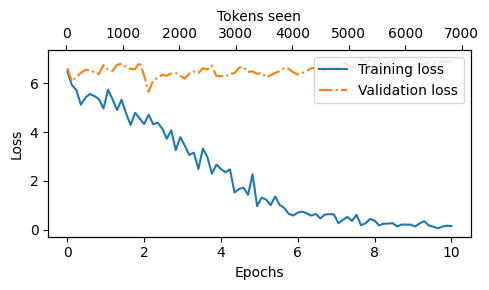

In [131]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 查看上面的结果，我们可以看到模型一开始会生成难以理解的字符串，而到最后，它能够生成语法或多或少正确的句子
- 但是，根据训练和验证集损失，我们可以看到模型开始过度拟合
- 如果我们检查它在最后写的几段话，我们会发现它们逐字逐句地包含在训练集中——它只是记住了训练数据
- 稍后，我们将介绍可以在一定程度上减轻这种记忆的解码策略
- 请注意，这里发生过度拟合是因为我们有一个非常非常小的训练集，并且我们对其进行了多次迭代
- 这里的 LLM 培训主要用于学习目的；我们主要想看看模型可以学会生成连贯的文本

### 3.4 保存模型权重

- 训练 LLM 的计算成本很高，因此能够保存和加载 LLM 权重至关重要
- PyTorch 中推荐的方式是通过将 `torch.save` 函数应用于 `.state_dict()` 方法来保存模型权重，即所谓的 `state_dict`
- 通常使用 Adam 或 AdamW 等自适应优化器来训练，这些自适应优化器会为每个模型权重存储额外的参数，因此如果我们计划稍后继续进行预训练，那么保存这些参数也是有意义的：

In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

加载的代码如下：

In [143]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_85M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

## 4. 文本生成

- 首先将上一节关于模型训练的代码移动到 `llm.py`
- 使用我们之前在简单训练函数中使用的 `generate_text_simple` 函数，可以一次生成一个标记的新文本
- 下一个生成的标记是词汇表中所有标记中概率得分最大的标记

In [147]:
from llm import SimpleTokenizer, create_vocab, GPTModel, generate_text_simple, text_to_token_ids, token_ids_to_text

GPT_CONFIG_85M = {
    "vocab_size": 323,      # 词汇表大小
    "context_length": 8,    # 上下文长度
    "emb_dim": 768,          # 嵌入维度
    "n_heads": 12,          # 注意力头数量
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout 率
    "qkv_bias": False       # Query-Key-Value bias
}


with open("the-road.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

tokenizer = SimpleTokenizer(vocab=create_vocab(raw_text=raw_text))

# 加载模型
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)
model = GPTModel(GPT_CONFIG_85M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.to("cpu")
model.eval()

start_text = "每一次努力都让你感动"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_text, tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_85M["context_length"]
)

print("输出文本:\n", token_ids_to_text(token_ids, tokenizer))

输出文本:
 每一次努力都让你感动。当我们的努力。每一点小，我们也是学习毅加实验有了


即使我们多次执行上面的生成文本函数，LLM 也始终会生成相同的输出。我们现在引入两个概念，即所谓的解码策略，来修改 `generate_text_simple`：*温度缩放* 和 *top-k* 采样，这些将允许模型控制生成文本的随机性和多样性。
- 温度缩放：使用 `torch.multinomial(probs, num_samples=1)` 从概率分布中采样下一个标记
- `Top-K` 采样：为了能够使用更高的温度来增加输出多样性并降低无意义句子的概率，我们可以将采样的标记限制为前 k 个最可能的标记：

In [148]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For 循环与之前相同：获取 logits，并且仅关注最后一个时间步
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 新功能：使用 top_k 采样过滤 logits
        if top_k is not None:
            # 仅保留top_k个值
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 新功能：应用温度缩放
        if temperature > 0.0:
            logits = logits / temperature

            # 应用 softmax 获取概率
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 从分布中抽样
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 否则与之前相同：获取具有最高 logits 值的词汇条目的 idx
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # 如果遇到序列结束标记并且指定了 eos_id，则提前停止生成
            break

        # 与之前相同：将采样索引附加到运行序列
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [149]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("每一次努力都让你感动", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_85M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每一次努力都让你感动。每一这个过我们也是学习间最家从中吸战付出努力。相此，以，以，用为边心怀感恩之最并学学习的财富终习。


## 结语

最后，我们完成了一个简单版的大模型，包括文本数据预处理、模型架构实现、模型训练和文本生成等，最后我们使用完整的代码来演示一下文本生成：

In [150]:
from llm import SimpleTokenizer, create_vocab, GPTModel, generate, text_to_token_ids, token_ids_to_text

with open("the-road.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

GPT_CONFIG_85M = {
    "vocab_size": 323,      # 词汇表大小
    "context_length": 8,    # 上下文长度
    "emb_dim": 768,          # 嵌入维度
    "n_heads": 12,          # 注意力头数量
    "n_layers": 12,         # 层数
    "drop_rate": 0.1,       # Dropout 率
    "qkv_bias": False       # Query-Key-Value bias
}

tokenizer = SimpleTokenizer(vocab=create_vocab(raw_text=raw_text))

# 加载模型
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)
model = GPTModel(GPT_CONFIG_85M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.to("cpu")
model.eval()

start_text = "每一次努力都让你感动"
token_ids = generate(
    model=model,
    idx=text_to_token_ids(start_text, tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_85M["context_length"]
)

print("输出文本:\n", token_ids_to_text(token_ids, tokenizer))

输出文本:
 每一次努力都让你感动。当我们的努力。每一点小，我们也是学习毅加实验有了


从输出的结果来看，内容也不尽人意，当然这个是因为我们的训练集太小了，我们可以选择一些公共数据集进行训练，以取得更好的结果，生成优质的文本，但这也需要更多的资源和时间。

另外，在最后我附上本文参考的内容：[Build a Large Language Model (From Scratch)](https://github.com/GavinHome/LLMs-from-scratch)
